## IMPORT PACKAGES


In [21]:
import pandas as pd
import os
from prophet import Prophet
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

## Loading data

In [4]:
abs_dir = 'C:/Users/Admin/OneDrive/Pulpit/prophet/extracted/'
all_files = [os.path.join(abs_dir, file) for file in os.listdir(abs_dir) if file.endswith('.csv')]
df_list = [pd.read_csv(file, encoding='latin', header=None) for file in all_files]
df = pd.concat(df_list, axis=0)

## Data preparation

In [5]:
df = df.rename(columns={0: "id_stacji", 1: "nazwa_stacji", 2: "rok", 3: "msc", 4: "opad", 8: "opad_max"})
df['ds'] = pd.to_datetime(df['rok'].astype(str) + '-' + df['msc'].astype(str), errors='coerce').dt.to_period('M').dt.to_timestamp() + pd.offsets.MonthEnd(0)
df = df[['nazwa_stacji', 'ds', 'opad', 'opad_max']]

## Box-Cox Transformation

In [6]:
#Adding 1 to precipitation to avoid a value of 0 before the Box-Cox transformation
df['opad'] += 1
df['opad_max'] += 1

df['y'], lam_opad = boxcox(df['opad'])
df['opad_max_transformed'], _ = boxcox(df['opad_max'])

## Selecting a station

#### KAÑCZUGA station

In [7]:
sample_station = df[df['nazwa_stacji'] == 'KAÑCZUGA']

## Division of data into training and test sets

In [8]:
split_point = int(len(sample_station) * 0.8)
train_df = sample_station.iloc[:split_point].copy()
test_df = sample_station.iloc[split_point:].copy()

## Fitting the Prophet model with fixed parameters

In [9]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.add_regressor('opad_max_transformed')
m.fit(train_df[['ds', 'y', 'opad_max_transformed']])

13:39:58 - cmdstanpy - INFO - Chain [1] start processing
13:39:58 - cmdstanpy - INFO - Chain [1] done processing


## Forecasting

In [10]:
future = m.make_future_dataframe(periods=len(test_df), freq='ME')
future = future.merge(sample_station[['ds', 'opad_max_transformed']], on='ds', how='left')
forecast = m.predict(future)

## Transform the prediction back

In [11]:
forecast['yhat_inversed'] = inv_boxcox(forecast['yhat'], lam_opad) - 1

## Model evaluation

In [12]:
test_df['y_inversed'] = inv_boxcox(test_df['y'], lam_opad) - 1
mse = mean_squared_error(test_df['y_inversed'], forecast['yhat_inversed'][-len(test_df):])
rmse = sqrt(mse)
print(f'Test RMSE: {rmse}')

Test RMSE: 12.994737934090125


## Actual vs. Forecasted Rainfall

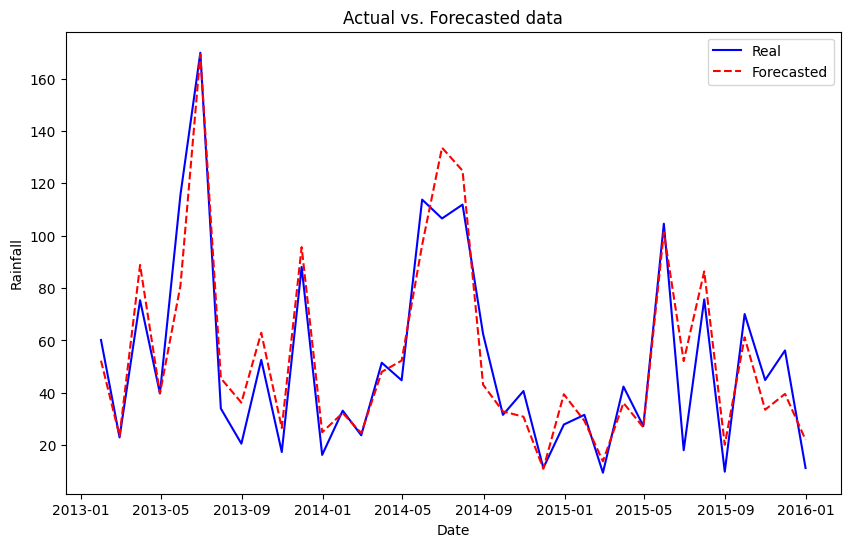

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['y_inversed'], 'b-', label='Real')
plt.plot(future['ds'][-len(test_df):], forecast['yhat_inversed'][-len(test_df):], 'r--', label='Forecasted')
plt.title('Actual vs. Forecasted data')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

## Actual vs. Forecasted Rainfall (Bar Chart)

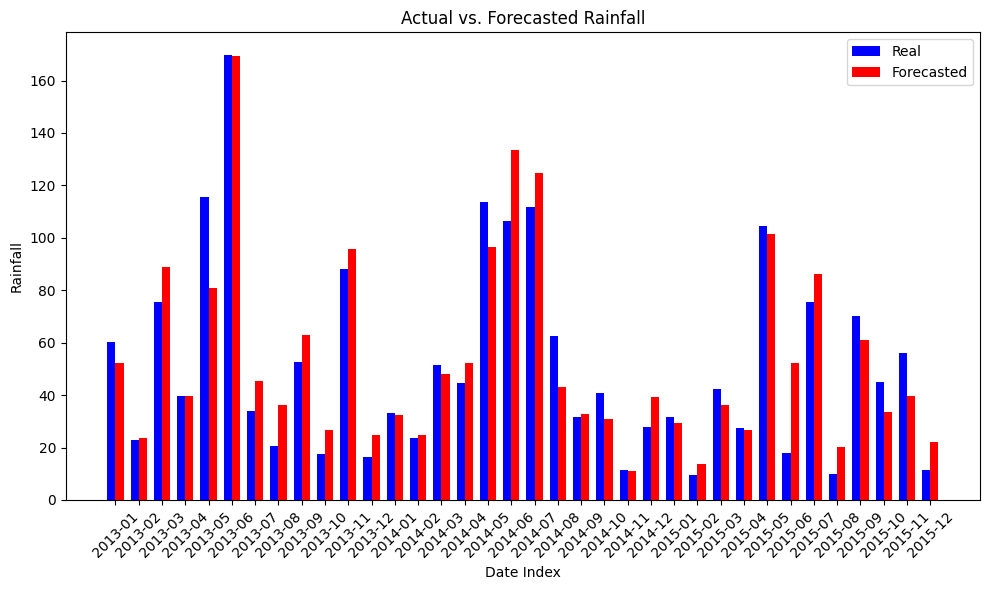

In [25]:
dates = np.arange(len(test_df))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(dates - width/2, test_df['y_inversed'], width, label='Real', color='blue')
plt.bar(dates + width/2, forecast['yhat_inversed'][-len(test_df):], width, label='Forecasted', color='red')

plt.title('Actual vs. Forecasted Rainfall')
plt.xlabel('Date Index')
plt.ylabel('Rainfall')
plt.legend()
plt.xticks(ticks=dates, labels=test_df['ds'].dt.strftime('%Y-%m').tolist(), rotation=45)
plt.tight_layout()
plt.show()

## Analysis of Rainfall Variability

<Figure size 1200x600 with 0 Axes>

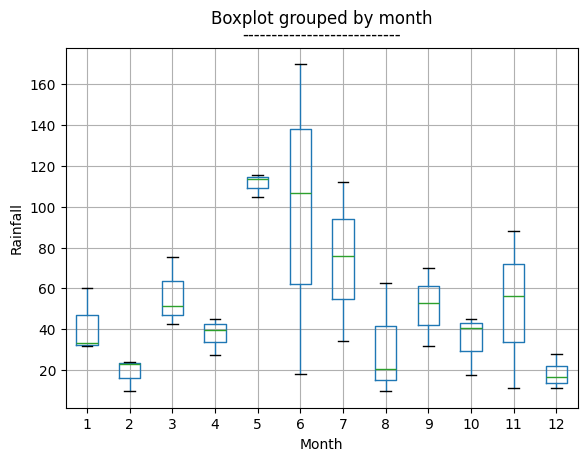

In [30]:
test_df['month'] = test_df['ds'].dt.month

plt.figure(figsize=(12, 6))
test_df.boxplot(column='y_inversed', by='month')
plt.title('---------------------------')
plt.xlabel('Month')
plt.ylabel('Rainfall')
plt.show()

## Scatter Plot of Actual vs. Forecasted Rainfall

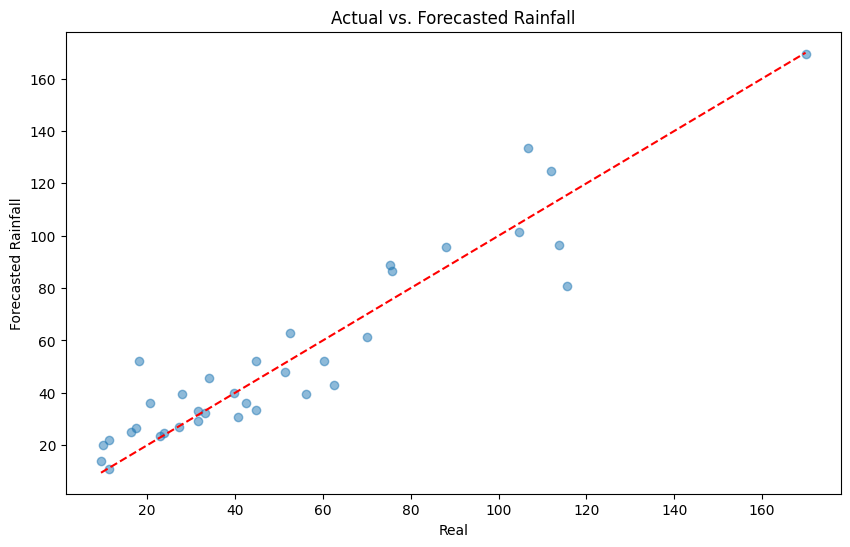

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(test_df['y_inversed'], forecast['yhat_inversed'][-len(test_df):], alpha=0.5)
plt.plot([test_df['y_inversed'].min(), test_df['y_inversed'].max()], [test_df['y_inversed'].min(), test_df['y_inversed'].max()], 'r--')
plt.title('Actual vs. Forecasted Rainfall')
plt.xlabel('Real')
plt.ylabel('Forecasted Rainfall')
plt.show()